# Removing Outliers by Image Entropy



### Imports

In [2]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask import bag
from tqdm import tqdm
from PIL import Image, ImageDraw

### Function Definitions

In [3]:
def entropy_it(x):
    counts = np.bincount(x)
    p = counts[counts > 0] / float(len(x))
    # compute Shannon entropy in bits
    return -np.sum(p * np.log2(p))

def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            draw.line([stroke[0][i], stroke[1][i], stroke[0][i+1], stroke[1][i+1]], fill=0, width=5)
    image = np.array(image)
    return entropy_it(image.flatten()), image

def plot_it(entropy, images, indices, n=5):
    fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(12, 10))
    for i, j in enumerate(indices[0][:n*n]):
        ax = axs[i // n, i % n]
        ax.set_title("%.4f" % entropy[j])
        ax.imshow(images[j], cmap="gray")
        ax.set_yticks([])
        ax.set_xticks([])
        plt.setp(ax.spines.values(), color="red")
    plt.subplots_adjust(bottom=-0.2)
    plt.show()
    

df deleted 227692544


In [6]:
reader = pd.read_csv('../input/train_simplified/tiger.csv', index_col=['key_id'], chunksize=1024)

data = []
for chunk in tqdm(reader):
    entropybag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    data.extend(entropybag.compute()) # PARALLELIZE

entropy, images = zip(*data)

119it [02:44,  1.54s/it]


 ## Class Distribution

In [7]:
threshold = 0.1
lower = np.percentile(entropy, 0.3)
upper = np.percentile(entropy, 98.5)
print(np.min(entropy), np.max(entropy))
print(lower, upper)

0.000501790558681815 0.9999989251081651
0.2418830413734464 0.7138227821702169


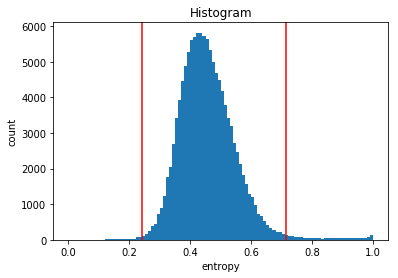

In [8]:
plt.title("Histogram")
plt.xlabel('entropy')
plt.ylabel('count')
plt.hist(entropy, bins=100)
plt.axvline(x=lower, color='r')
plt.axvline(x=upper, color='r')

 ## Outliers with a low entropy

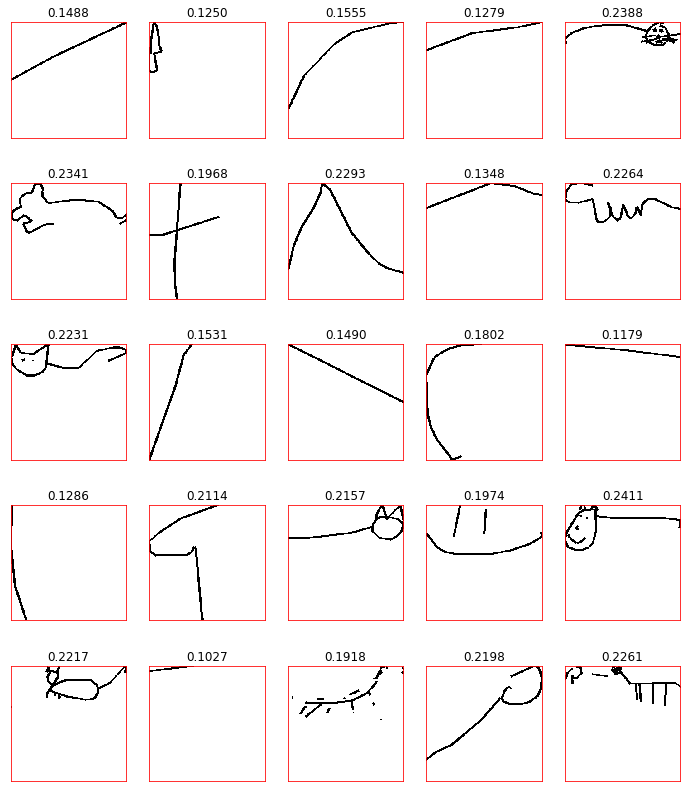

In [9]:
plot_it(entropy, images, np.where(entropy < lower))

## Outliers with a high entropy

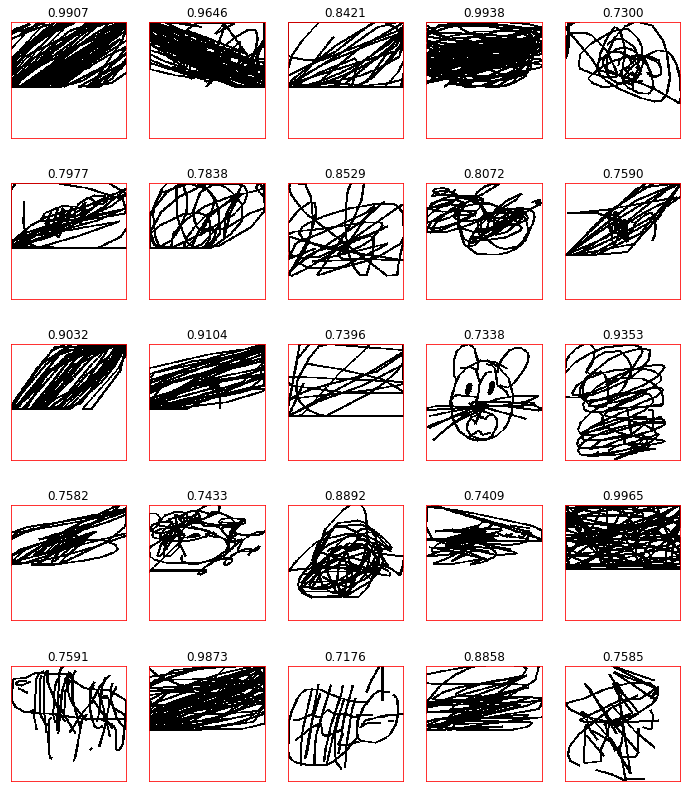

In [10]:
plot_it(entropy, images, np.where(entropy > upper))